In [ ]:
!pip install sklearn
!pip install seaborn

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pandas as pd
from datetime import datetime
%load_ext tensorboard

In [62]:
!pip install tqdm

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence


In [5]:
def process_all_datasets(base_path, snr_min, snr_max, window_size):
    X_sequences = []
    y_sequences = []

    labels = list("ABC")

    for label_name in labels:
        label_path = os.path.join(base_path, label_name)
        if not os.path.exists(label_path):
            print(f"[WARNING] Label {label_name} not found, skipped.")
            continue

        for person_name in os.listdir(label_path):
            person_path = os.path.join(label_path, person_name)
            if not os.path.isdir(person_path):
                continue

            for root, _, files in os.walk(person_path):
                for file in files:
                    if not file.endswith(".csv"):
                        continue

                    df = pd.read_csv(os.path.join(root, file))
                    df["SNR"] = np.clip(df["SNR"], snr_min, snr_max)
                    df["SNR"] = np.log1p(df["SNR"])

                    unique_ts = np.sort(df["timestamp"].unique())

                    for window_idx in range(len(unique_ts) - window_size + 1):
                        ts_slice = unique_ts[window_idx : window_idx + window_size]
                        df_slice = df[df["timestamp"].isin(ts_slice)]

                        if df_slice.empty:
                            continue

                        def resize(img):
                            img = Image.fromarray(img.astype(np.uint8))
                            img = img.resize((64, 64), Image.LANCZOS)
                            return np.array(img)

                        def make_heatmap(x, y, bins_x, bins_y):
                            heatmap, _, _ = np.histogram2d(x, y, bins=[bins_x, bins_y], weights=df_slice["SNR"])
                            count, _, _ = np.histogram2d(x, y, bins=[bins_x, bins_y])
                            count[count == 0] = 1
                            heatmap = heatmap / count
                            return heatmap.T

                        num_bins = 100
                        dop_bins = np.linspace(df_slice["doppler"].min(), df_slice["doppler"].max(), num_bins)
                        x_bins = np.linspace(df_slice["x"].min(), df_slice["x"].max(), num_bins)
                        y_bins = np.linspace(df_slice["y"].min(), df_slice["y"].max(), num_bins)
                        z_bins = np.linspace(df_slice["z"].min(), df_slice["z"].max(), num_bins)

                        dr = resize(make_heatmap(df_slice["doppler"], df_slice["x"], dop_bins, x_bins))
                        dt = resize(make_heatmap(df_slice["doppler"], df_slice["y"], dop_bins, y_bins))
                        dz = resize(make_heatmap(df_slice["doppler"], df_slice["z"], dop_bins, z_bins))

                        heatmap = np.stack([dr, dt, dz], axis=-1)
                        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

                        X_sequences.append(heatmap)
                        y_sequences.append(ord(label_name) - ord('A'))

    X_sequences = np.array(X_sequences, dtype=np.float32)
    y_sequences = np.array(y_sequences)
    return X_sequences, y_sequences

In [6]:
X, y = process_all_datasets(
    base_path="dataset 2",
    snr_min=4,
    snr_max=843,
    window_size=5
)

print(f"✅ X shape: {X.shape}")
print(f"✅ y shape: {y.shape}")

✅ X shape: (3282, 64, 64, 3)
✅ y shape: (3282,)


In [7]:
seq_len = 30
X_seq = []
y_seq = []

for i in range(len(X) - seq_len):
    X_seq.append(X[i:i+seq_len])
    y_seq.append(y[i+seq_len-1])  # Last label

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

print(f"✅ X_seq shape: {X_seq.shape}")
print(f"✅ y_seq shape: {y_seq.shape}")

✅ X_seq shape: (3252, 30, 64, 64, 3)
✅ y_seq shape: (3252,)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (2601, 30, 64, 64, 3), Test: (651, 30, 64, 64, 3)


In [14]:
class RadarSequence(Sequence):
    def __init__(self, X, y, batch_size=30, shuffle=True):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.X))
        self.on_epoch_end()
    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))
    def __getitem__(self, idx):
        batch_idx = self.indexes[idx * self.batch_size: (idx + 1) * self.batch_size]
        return self.X[batch_idx], self.y[batch_idx]
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [15]:
model = Sequential([
    TimeDistributed(Conv2D(16, (3,3), activation='relu', padding='same'),
                    input_shape=X_train.shape[1:]),
    TimeDistributed(MaxPooling2D((2,2))),
    TimeDistributed(Conv2D(32, (3,3), activation='relu', padding='same')),
    TimeDistributed(MaxPooling2D((2,2))),
    TimeDistributed(Flatten()),
    LSTM(64),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y)), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

d:\FILE TA DISINI SEMUA BRO\RADAR THINGS\TAIQBAL\temp-main\.venv\lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_5              │ (None, 30, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 30, 32, 32, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 30, 32, 32, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 30, 16, 16, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 30, 8192)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │     2,113,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,121,059 (8.09 MB)

 Trainable params: 2,121,059 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

train_seq = RadarSequence(X_train, y_train, batch_size=30)
test_seq  = RadarSequence(X_test, y_test, batch_size=30, shuffle=False)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_seq,
    validation_data=test_seq,
    epochs=30,
    callbacks=[early_stop],
    class_weight=class_weights
)

# ============================================
# 📌 9. Evaluate
# ============================================

y_pred = model.predict(test_seq)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()

Epoch 1/30


d:\FILE TA DISINI SEMUA BRO\RADAR THINGS\TAIQBAL\temp-main\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 599s 7s/step - accuracy: 0.3792 - loss: 1.0809 - val_accuracy: 0.6728 - val_loss: 0.8234
Epoch 2/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 547s 6s/step - accuracy: 0.8349 - loss: 0.5315 - val_accuracy: 0.9939 - val_loss: 0.0883
Epoch 3/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 545s 6s/step - accuracy: 0.9745 - loss: 0.1334 - val_accuracy: 0.7481 - val_loss: 0.8080
Epoch 4/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 655s 8s/step - accuracy: 0.9575 - loss: 0.1564 - val_accuracy: 0.9985 - val_loss: 0.0033
Epoch 5/30
12/87 ━━━━━━━━━━━━━━━━━━━━ 8:00 6s/step - accuracy: 1.0000 - loss: 0.0134

KeyboardInterrupt: 

In [109]:
model.save('LSTM.h5')

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# 👇 Load your trained model (adjust filename)
model = load_model("LSTM.h5")  # or .keras or saved_model path

✅ Training heatmap shape: (1, 64, 64, 3)
min: 0.0 max: 1.0


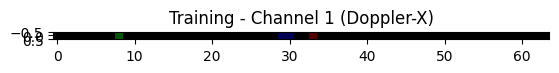

In [111]:
# 👇 Example: assume you saved training heatmaps as numpy arrays
# If not, load directly from your X_train:
train_heatmap = X_train[0]

print("✅ Training heatmap shape:", train_heatmap.shape)
print("min:", train_heatmap.min(), "max:", train_heatmap.max())
plt.imshow(train_heatmap[:, :, 0])  # show first channel
plt.title("Training - Channel 1 (Doppler-X)")
plt.show()

In [112]:
# 👇 Example: save live heatmap during run
# np.save("live_heatmap.npy", heatmap_rgb)

live_heatmap = np.load("live_heatmap.npy")

print("✅ Live heatmap shape:", live_heatmap.shape)
print("min:", live_heatmap.min(), "max:", live_heatmap.max())
plt.imshow(live_heatmap[:, :, 0])
plt.title("Real-time - Channel 1 (Doppler-X)")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'live_heatmap.npy'

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

#!rm -rf ./logs/

logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, write_graph=True)


# Training model
history = tuner.search(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    class_weight=class_weights,
    validation_data=(X_test, y_test),
    callbacks=[early_stop,tensorboard_callback],
    verbose=1
)



In [ ]:
best_trial = tuner.oracle.get_best_trials(num_trials = 1)[0]

print(best_trial.metrics)

In [ ]:
!pip install visualkeras 
!pip install --upgrade visualkeras

In [ ]:

bestmodel = tuner.get_best_models(1)[0]
bestmodel.save("a-z(30).h5")


In [ ]:
best_model = tuner.get_best_models(1)[0]



y_pred = best_model.predict(X_test) 
y_pred_classes = y_pred.argmax(axis=1)  
print(classification_report(y_test, y_pred_classes))
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['A', 'B', 'C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'],
            yticklabels=['A', 'B', 'C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hp)

history = best_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    class_weight=class_weights,
    validation_data=(X_test, y_test),
    callbacks=[early_stop,tensorboard_callback],
    verbose=1
)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train vs Validation Accuracy')

plt.show()

In [ ]:
best_mod = tuner.get_best_models(1)[0]

best_mod.save("random.h5")




In [ ]:
import visualkeras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# Assuming your model is built using `tuner.get_best_models(1)[0]`
model = tuner.get_best_models(1)[0]



visualkeras.layered_view(model, legend=True, show_dimension=True)

In [ ]:
model.save("coba_coba2.h5")